In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.ndimage import gaussian_filter1d
from pyonset import Onset, BootstrapWindow
from anisotropy import run_SEPevent
from statsmodels.tsa.stattools import acf

In [43]:
data_path = f"{os.getcwd()}{os.sep}data"
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"

date = pd.to_datetime("2023-02-20")

start = date - pd.Timedelta(days=1)
end = date + pd.Timedelta(days=2)    # off by one, so three days are loaded now

event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, 
                    species="e", channels=3, averaging="1min")     

Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.


15-Nov-25 17:08:12: File is current: /home/osant/gradu/data/wind_masters/wi_h0_mfi_00000000_v01.cdf
15-Nov-25 17:08:12: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/
15-Nov-25 17:08:13: File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230219_v05.cdf
15-Nov-25 17:08:13: File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230220_v05.cdf
15-Nov-25 17:08:14: File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230221_v05.cdf


(<Figure size 800x500 with 5 Axes>,
 array([<Axes: title={'center': 'Wind'}>,
        <Axes: ylabel='Pitch angle [$\\degree$]'>,
        <Axes: xlabel='Universal Time (UT)', ylabel='Intensity\n [1/(s$\\,$cm²$\\,$sr$\\,$MeV)]'>],
       dtype=object))

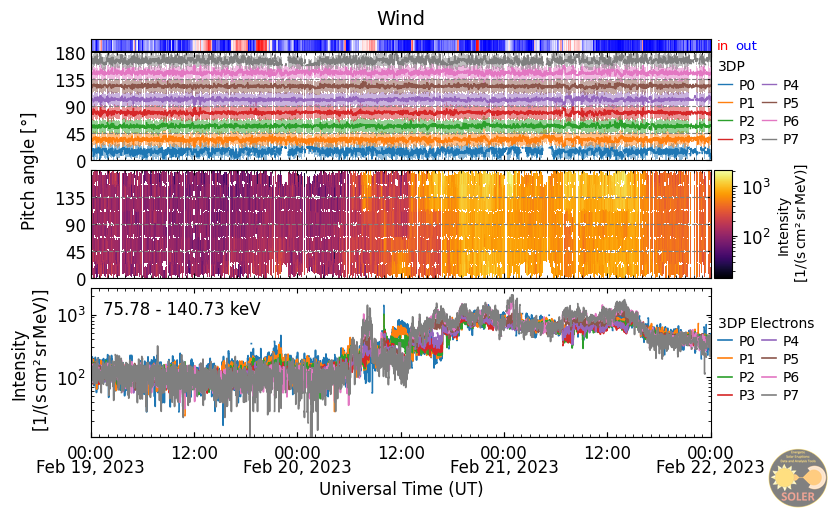

In [44]:
event.overview_plot()

In [60]:
class RollingBackground():
    def __init__(self, flux, viewing, start=None, end=None, shift_hrs=1):
        self.flux = flux
        if start is None:
            self.start = flux.index[0]
        else:
            self.start = start
        if end is None:
            self.end = flux.index[0] + pd.Timedelta(hours=12)
        else:
            self.end = end

        self.viewing = viewing
        self.length = (self.end - self.start).total_seconds() / 60 / 60
        self.shift_hrs = shift_hrs

    def get_window_lims(self):
        return (self.start, self.end)
    
    def reset(self):
        self.start = self.flux.index[0]

    def roll(self):
        self.start += pd.Timedelta(hours=self.shift_hrs)
        self.end += pd.Timedelta(hours=self.shift_hrs)
        
    def acf(self, **kwargs):
        return acf(self.flux.loc[(self.start):(self.end), self.viewing], **kwargs)

In [61]:
data = pd.DataFrame(event.I_data, index=event.I_times)
data

,0,1,2,3,4,5,6,7
Epoch,,,,,,,,
2023-02-19 00:00:30.436,90.120605,108.523857,147.683960,95.128311,114.915215,113.609985,139.432190,125.668320
2023-02-19 00:01:30.436,146.445984,111.637932,142.219193,94.765564,96.679619,133.581024,112.762184,68.546356
2023-02-19 00:02:30.436,112.650757,152.755737,133.040970,125.935692,120.527077,114.752541,155.325363,114.243919
2023-02-19 00:03:30.436,136.276947,140.020416,116.455811,112.101898,122.950150,157.206604,109.499802,138.026016
2023-02-19 00:04:30.436,205.726318,167.194992,133.320679,123.065811,113.142830,143.673706,100.144714,131.062393
...,...,...,...,...,...,...,...,...
2023-02-21 23:55:30.436,371.747467,402.558350,358.902222,390.493683,347.697479,350.013916,409.213898,359.868347
2023-02-21 23:56:30.436,337.952271,387.990204,394.806030,370.690002,391.906891,380.634888,381.975494,319.882965
2023-02-21 23:57:30.436,260.504852,395.871857,408.714966,406.985931,411.547241,335.335449,341.912140,210.637222


In [62]:
bg = RollingBackground(data, 3)

<BarContainer object of 11 artists>

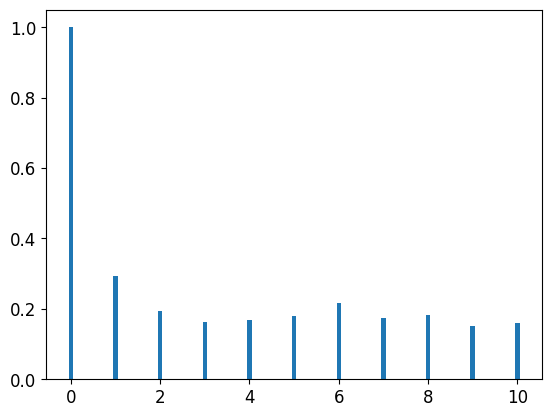

In [63]:
bg.roll()
bg_acf = bg.acf(nlags=10, missing="conservative")
plt.bar(x=range(len(bg_acf)), height=bg_acf, width=.1)

In [72]:
bg.reset()

In [77]:
for i in range(10):
    bg_acf, q, p = bg.acf(nlags=10, missing="conservative", qstat=True)
    print(bg.get_window_lims())
    print(p)
    bg.roll()
    # fig, ax = plt.subplots()
    # ax.bar(range(len(bg_acf)), bg_acf, width=.1)
bg.reset()

(Timestamp('2023-02-19 00:00:30.436000'), Timestamp('2023-02-24 04:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 01:00:30.436000'), Timestamp('2023-02-24 05:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 02:00:30.436000'), Timestamp('2023-02-24 06:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 03:00:30.436000'), Timestamp('2023-02-24 07:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 04:00:30.436000'), Timestamp('2023-02-24 08:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 05:00:30.436000'), Timestamp('2023-02-24 09:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 06:00:30.436000'), Timestamp('2023-02-24 10:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 07:00:30.436000'), Timestamp('2023-02-24 11:00:30.436000'))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(Timestamp('2023-02-19 08:00:30.436000'), Timestamp('2023-02-24 12:00:30.436000'